### 第7天：TensorFlow2构建数据管道—Numpy array格式


**tf.data**提供了快速、灵活、易于使用的数据管道，同时还提供同步的训练，所谓同步训练就是利用CPU处理数据，供给GPU或者TPU(如果有的话)来训练数据。将数据集转变为数据管道的形式，有助于提升训练的效率。下面通过实例Numpy array格式数据集如何构建数据管道，以及数据的预处理、模型的训练和最终结果的展示。

### 实例：数字0-9和字母A-Z识别
数据集说明：

+ 该数据集有36个类别标签：数字0-9，字母A-Z；
+ 每个类别对应一个数组，数组的长度为39，也就是说每个类别有39个样本；
+ 数组的元素是一个维度为(20, 16)的数组，数组中的元素为0或者1；


###  0、可视化Tensorboard 

打开**Anaconda Prompt**, 激活环境**activate tf2**，安装**pip install jupyter-tensorboard**。 

In [1]:
%%time
# 上面的语句可以查看每个单元格执行完用的时间
# 注意上面计时的命令只能在单元格的第一行，并且后面不能有任何的字符，空格也不行，否则都会报错
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS' 
plt.rcParams['axes.unicode_minus']=False
import os, datetime
print('tensorflow版本：', tf.__version__)

tensorflow版本： 2.1.0
CPU times: user 1.3 s, sys: 206 ms, total: 1.51 s
Wall time: 1.52 s


### 1、Numpy array格式：数字0-9和字母A-Z识别数据集

### 1.1 数据获取

In [2]:
# binary_alpha_digits格式的数据集的网址
Data_Url_Mnist ='https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat'
#  文件下载到制定的路径
Path_Mnist = tf.keras.utils.get_file(r'/Users/anfany/Documents/编程/tf_28_days/binaryalphadigs.mat', Data_Url_Mnist)

532480/532304 [==============================] - 35s 66us/step


In [3]:
# 解析数据，因为原始数据格式为mat格式
import scipy.io as scio
matdata = scio.loadmat(Path_Mnist)
# 打印标签
label_data  = np.array([c[0] for c in matdata['classlabels'][0]])
print('标签：', label_data)
# 特征数据
feature_data = matdata['dat']
print('特征数据维度：', feature_data.shape)

标签： ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
特征数据维度： (36, 39)


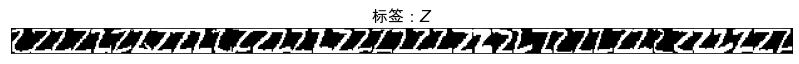

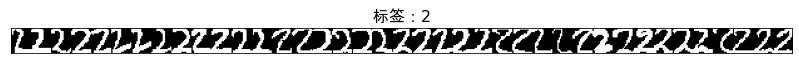

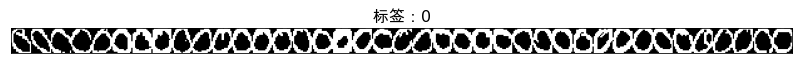

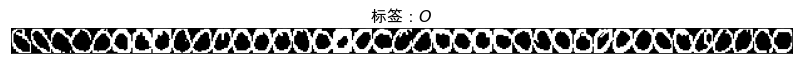

In [4]:
# 显示第n列数据
def show(feadata, labedata, n):  # n为类别的索引
    plt.figure(figsize=(14, 10))
    # 添加标签
    plt.title('标签：${}$'.format(labedata[n]), fontsize=16)
    # 关闭坐标轴
    plt.xticks([])
    plt.yticks([])
    # 显示图片：因为每条数据其实有39个样本，先将样本连接起来
    one_data = feadata[n][0]
    for kk in feadata[n][1:]:
        one_data = np.hstack((one_data, kk))
    plt.imshow(one_data, 'gray')  # 显示为灰度图片

# 索引为35的类别是Z
show(feature_data, label_data, 35)

# 索引为2的类别是2
show(feature_data, label_data, 2)

# 需要注意的是：数据集中的数字0类和大写字母O类是一样的数据。原始数据集存在错误
show(feature_data, label_data, 0)
show(feature_data, label_data, 24)

### 1.2 Numpy格式数据

In [21]:
# 首先将标签数据变为整数型
Label_Dict = {}
New_Label = []
for index, value in enumerate(label_data):
    Label_Dict[index] = value
    New_Label.append(index)
New_Label = np.array(New_Label)
    

In [22]:
# 数据变为特征、标签数据
all_feature_data = []
for c in feature_data:
    for s in c:
        all_feature_data.append(s)
# 特征数据
all_feature_data = np.array(all_feature_data)
# 标签数据:扩充39次
all_label_data = New_Label.repeat(39)
print(all_feature_data.shape)
print(all_label_data.shape)

(1404, 20, 16)
(1404,)


In [23]:
# 在这里将数据集按照比例分割为训练、验证、测试数据集，保证每个数据集中每个类别的样本数相同
def split_data(fdata, ldata, valid_p=0.15, test_p=0.1, length=36, count=39, model='cnn'):
    
    f_split = np.array_split(fdata, length)
    l_split = np.array_split(ldata, length)
    
    train_f_data = []
    train_l_data = []
    
    valid_f_data = []
    valid_l_data = []
    
    test_f_data = []
    test_l_data = []
    
    for index, value in enumerate(f_split):
        all_ind = np.random.permutation(count)
        
        valid_c = int(count * valid_p)
        test_c = int(count * test_p)
        
        valid_index = all_ind[:valid_c]
        test_index = all_ind[valid_c: (valid_c + test_c)]
        train_index = all_ind[(valid_c + test_c):]
        
        try:
            train_f_data = np.vstack((train_f_data, value[train_index]))
            train_l_data = np.hstack((train_l_data, l_split[index][train_index])) 
    
            valid_f_data = np.vstack((valid_f_data, value[valid_index]))
            valid_l_data = np.hstack((valid_l_data, l_split[index][valid_index]))
    
            test_f_data = np.vstack((test_f_data, value[test_index]))
            test_l_data = np.hstack((test_l_data, l_split[index][test_index]))
        except ValueError:
            train_f_data = value[train_index]
            train_l_data = l_split[index][train_index]
    
            valid_f_data = value[valid_index]
            valid_l_data = l_split[index][valid_index]
    
            test_f_data = value[test_index]
            test_l_data = l_split[index][test_index]
    # 如果要建立CNN模型，特征数据需要增加维度
    if model == 'cnn':
        train_f_data = train_f_data[:, :, :, None] # 增加维度
        valid_f_data = valid_f_data[:, :, :, None]
        test_f_data  = test_f_data[:, :, :, None]
        
    # 训练数据集较少，在这里重复
    train_f_data = train_f_data.repeat(5, axis = 0)
    train_l_data = train_l_data.repeat(5, axis = 0)
            
    return train_f_data, train_l_data, valid_f_data, valid_l_data, test_f_data, test_l_data

# 分割后的数据集：注意CNN和MLP模型需要不同维度的数据
Tr_f, Tr_l, Va_f, Va_l, Te_f, Te_l = split_data(all_feature_data, all_label_data, model='cnn')    
print(Tr_f.shape)

(5580, 20, 16, 1)


### 1.2 构建数据管道

In [24]:
# 下面就是将特征和标签对应起来，也就是每个(20, 16)对应一个label，并且都转换为张量的形式
# 训练数据集:因为训练数据集较少，重复数据
train_data = tf.data.Dataset.from_tensor_slices((Tr_f, Tr_l))
# 验证数据集
valid_data = tf.data.Dataset.from_tensor_slices((Va_f, Va_l))
# 测试数据集
test_data = tf.data.Dataset.from_tensor_slices((Te_f, Te_l))
# 预测数据集：这里用测试数据集充当预测数据集
predict_data = tf.data.Dataset.from_tensor_slices(Te_f)

train_data

<TensorSliceDataset shapes: ((20, 16, 1), ()), types: (tf.uint8, tf.int64)>

In [25]:
# 可以通过下面的命令，查看前10条数据，因为占用页面，此处不打印结果
# for sa in train_data.take(10):
#     print(sa)

### 1.3 数据管道进入模型

In [26]:
# 需要将数据打乱分组：
# shuffle的数值越大，占用内存越多；数值越小，打乱不充分
train_data_sb = train_data.shuffle(20000).batch(300)  # 每200条数据进行乱序，一次批训练的数据条数为32。

valid_data_b = valid_data.batch(16)
test_data_b = test_data.batch(16)
predict_data_b = predict_data.batch(16)

# 代入模型需要数据的维度,通过下面的命令可以得到对应的为维度。
X, Y = next(iter(train_data_sb))
Input_Shape = X.numpy().shape[1:]
print(Input_Shape)
Out_Class = 36 # 总共类别数

(20, 16, 1)


### 1.4 利用Sequential API建立模型

In [27]:
# Sequential API建立MLP模型
def build_model_mlp(name='python_fan', inputshape=Input_Shape):  # name:模型的名称
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=inputshape, name='transpose_1'),  # 输入层
        tf.keras.layers.Dense(128, name='hidden_layer_1', activation='relu', kernel_regularizer='l2'), # 隐层1，L2正则化防止过拟合
        tf.keras.layers.Dense(256, name='hidden_layer_2', activation='relu', kernel_regularizer='l2'), # 隐层2，L2正则化防止过拟合
        tf.keras.layers.Dropout(0.2),  # 丢弃层，防止过拟合
        tf.keras.layers.Dense(Out_Class, name='hidden_layer_3', activation='softmax', kernel_regularizer='l2') # 输出层
        ], name=name)
    model.compile(optimizer=tf.keras.optimizers.Adagrad(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  
    return model


In [28]:
# Sequential API建立CNN模型
def build_model_cnn(name='python_fan', inputshape=Input_Shape):  # name:模型的名称
    model = tf.keras.Sequential([
        tf.keras.Input(shape=Input_Shape, name='INPUT'),# 输入层
        
        tf.keras.layers.Conv2D(filters=64, kernel_size=[2, 2], activation='relu', name='CONV_1'), # 卷积层
        tf.keras.layers.MaxPooling2D(pool_size=[2,2], name='MAXPOOL_1', padding='same'), # 最大池化层
        
        tf.keras.layers.Conv2D(filters=64, kernel_size=[2,2], activation='relu', name='CONV_2'), # 卷积层
        tf.keras.layers.MaxPooling2D(pool_size=[2,2], name='MAXPOOL_2', padding='same'), # 最大池化层
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(64, name='hidden_layer_1', activation='relu', kernel_regularizer='l2'), # 隐层，L2正则化防止过拟合
        tf.keras.layers.Dropout(0.32),  # 丢弃层，防止过拟合
        
        tf.keras.layers.Dense(Out_Class, name='hidden_layer_2', activation='softmax', kernel_regularizer='l2') # 输出层
    ], name=name)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  
    return model


### 1.5 模型训练

In [29]:
# 建立CNN模型
model = build_model_cnn('CNN')

In [30]:
# 回调:将训练过程写入到文件夹内，
logpath = os.path.join(r'logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logpath, histogram_freq=1)

In [31]:
# 回调：动态更改学习率 
def scheduler(epoch):  # 根据epoch动态更改学习率的参数
    if epoch < 20:
        return 0.014
    else:
        return 0.014 * tf.math.exp(0.1 * (20 - epoch))
    
lr_back = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [32]:
# 回调：保存验证准确度最高的模型
checkpoint_path = "./cp-{val_accuracy:.5f}.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 创建一个回调，保证验证数据集准确率最大，save_weights_only=False，保存整个模型结构+参数
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False, monitor='val_accuracy',
                                                 mode='max', verbose=2, save_best_only=True)

In [33]:
# 模型训练
model.fit(train_data_sb, epochs=60, validation_data=valid_data_b, callbacks=[lr_back, tensorboard_callback, cp_callback])

Train for 19 steps, validate for 12 steps
Epoch 1/60
18/19 [===========================>..] - ETA: 0s - loss: 3.6244 - accuracy: 0.1617
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to ./cp-0.50000.h5
19/19 [==============================] - 2s 80ms/step - loss: 3.5527 - accuracy: 0.1695 - val_loss: 2.0763 - val_accuracy: 0.5000
Epoch 2/60
18/19 [===========================>..] - ETA: 0s - loss: 1.7845 - accuracy: 0.5991
Epoch 00002: val_accuracy improved from 0.50000 to 0.67222, saving model to ./cp-0.67222.h5
19/19 [==============================] - 1s 61ms/step - loss: 1.7680 - accuracy: 0.6027 - val_loss: 1.6391 - val_accuracy: 0.6722
Epoch 3/60
18/19 [===========================>..] - ETA: 0s - loss: 1.3987 - accuracy: 0.7357
Epoch 00003: val_accuracy improved from 0.67222 to 0.72778, saving model to ./cp-0.72778.h5
19/19 [==============================] - 1s 61ms/step - loss: 1.3936 - accuracy: 0.7371 - val_loss: 1.4415 - val_accuracy: 0.7278
Epoch 4/60
18

In [34]:
# 加载最好的模型：最好的模型可通过上面的输出得到“val_accuracy did not improve from 0.84444”。所以文件名就是cp-0.84444.h5
best_model = tf.keras.models.load_model('cp-0.85000.h5')

In [35]:
# 模型评估
best_model.evaluate(test_data_b)

7/7 [==============================] - 0s 15ms/step - loss: 0.7648 - accuracy: 0.8056


[0.7648465377943856, 0.8055556]

### 1.7 TensorBoard 训练过程可视化

在保存本ipynb的路径中，可以找到刚才指定的文件夹，选中该文件夹，上面会出现tensorboard。点击即可跳转到相应的页面。https://github.com/Anfany/Learning-TensorFlow2-in-28-days/blob/master/7.0.jpeg

+ **查看精确度与成本:https://github.com/Anfany/Learning-TensorFlow2-in-28-days/blob/master/7.1.png**

+ **查看学习率:https://github.com/Anfany/Learning-TensorFlow2-in-28-days/blob/master/7.2.png**

+ **查看模型构造:https://github.com/Anfany/Learning-TensorFlow2-in-28-days/blob/master/7.3.png**

+ **查看参数分布:https://github.com/Anfany/Learning-TensorFlow2-in-28-days/blob/master/7.1.png**

### 1.8 结果展示

In [38]:
# 模型预测
result = model.predict(predict_data_b)
# 模型预测的类别
class_result = tf.argmax(result, axis=1).numpy()

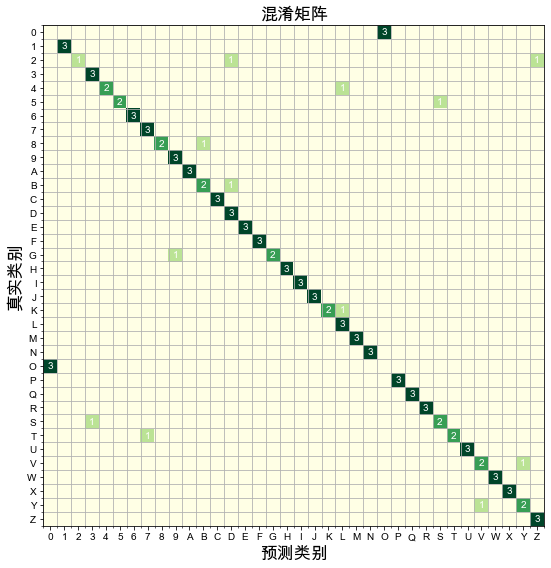

In [39]:
# 输出混淆矩阵:根据真实类别列表、预测类别列表、数字与类别的对应字典
from matplotlib.ticker import MultipleLocator
def plot_confusion_matrix(realclass, predictclass, classdigdict, classcount=36):
    con_mat = tf.math.confusion_matrix(realclass, predictclass, num_classes=classcount).numpy()
    class_sign = [classdigdict[k] for k in range(classcount)]
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(con_mat,cmap="YlGn")

    ax.set_xticks(np.arange(len(class_sign)))
    ax.set_yticks(np.arange(len(class_sign)))
    ax.set_xticklabels(class_sign)
    ax.set_yticklabels(class_sign)
    ax.set_ylabel('真实类别', fontsize=17)
    ax.set_xlabel('预测类别', fontsize=17)
    
    xminorLocator = MultipleLocator(.5)
    yminorLocator = MultipleLocator(.5)

    for i in range(classcount):
        for j in range(classcount):
            if con_mat[i, j]:
                ax.text(j, i, con_mat[i, j], ha="center", va="center", color="w")
    ax.set_title('混淆矩阵', fontsize=17)
    
    ax.xaxis.set_minor_locator(xminorLocator) 
    ax.yaxis.set_minor_locator(yminorLocator) 
    ax.xaxis.grid(True, which='minor') 
    ax.yaxis.grid(True, which='minor') 
    
    fig.tight_layout()
    plt.show()
plot_confusion_matrix(Te_l, class_result, Label_Dict)     